<a href="https://colab.research.google.com/github/Mancupfire/VinIndoorCare/blob/main/Single_Variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import keras
import os
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta

In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [7]:
# Define helper functions
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix

# Interpolate the NaN values
def interpolate(data, mask):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            if temp[i][j] == mask:
                temp[i][j] = float("NaN")
        df = pd.Series(temp[i]).interpolate(method='linear')
        d.append(df.tolist())
    return d

def split_train(Int_dat, Norm_dat, T1, T2, T3, Stride, start, end, data_name):
    length = len(Int_dat[0])
    s = int(length * start)
    e = int(length * end)
    Train = [N[:s] + N[e:] for N in Norm_dat]
    Test = [M[s:e] for M in Int_dat]
    print('Training Data Length: ', len(Train), 'X', len(Train[0]))
    print('Test Data Length: ', len(Test), 'X', len(Test[0]))
    print('Testing percentage: ', len(Test[0])/(len(Test[0])+len(Train[0]))*100, '%')
    train_x, train_y = data_split(Train, T1, T2, T3, Stride)
    test_x, test_y = data_split(Test, T1, T2, T3, Stride)
    return train_x, train_y, test_x, test_y

def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    while i + period <= len(dat[0]):
        x_temp = []
        y_temp = []
        for j in range(len(dat)):
            x_temp.append(dat[j][i:i + train_hour])
            y_temp.append(dat[j][i + train_hour + predict_position:i + train_hour + predict_position + test_hour])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)

def data_normalize(Dat):
    new_dat = []
    for d in Dat:
        valid_vals = [val for val in d if val != -1]
        min_val = np.min(valid_vals) if valid_vals else 0
        max_val = np.max(valid_vals) if valid_vals else 1
        temp = []
        for val in d:
            if val == -1:
                temp.append(val)
            else:
                # Min-max scaling
                norm = (val - min_val) / (max_val - min_val) if max_val != min_val else 0
                temp.append(norm)
        new_dat.append(temp)
    return new_dat, [(min_val, max_val) for min_val, max_val in [(np.min([val for val in d if val != -1]), np.max([val for val in d if val != -1])) for d in Dat]]

# Load and align data for each sensor pair
def load_and_align_data(sensor_files, variables):
    data = []
    variable_names = []
    time_index = None

    for sensor_name, file_path in sensor_files.items():
        # Load data
        df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')
        df.fillna(-1, inplace=True)

        # Align time index
        if time_index is None:
            time_index = df.index
        else:
            time_index = time_index.intersection(df.index)

    # After determining common time index, extract data
    for sensor_name, file_path in sensor_files.items():
        df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')
        df.fillna(-1, inplace=True)

        # Extract each variable and add to the data list
        for var in variables:
            if var in df.columns:
                # Use the common time index for all data
                aligned_data = df.loc[time_index, var].tolist()
                data.append(aligned_data)
                variable_names.append(f"{sensor_name}_{var}")

    return data, variable_names, time_index

def stacked_LSTM(X, Y):
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    model = Sequential()
    model.add(Masking(mask_value=-1., input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model.add(Dense(out))
    model.compile(loss='mean_absolute_error',optimizer=keras.optimizers.Adam(learning_rate=1e-5))

    # Add early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    hist = model.fit(X, Y, epochs=50, validation_split=0.2, verbose=1, batch_size=10, callbacks=[early_stopping])
    model.summary()
    return model, hist

def SP_Learner(data, train_time, predict_time, predict_position, Stride, start, end, data_name):
    norm_dat, scaling_params = data_normalize(data)
    norm_int_dat = interpolate(norm_dat, -1)
    train_x, train_y, test_x, test_y = split_train(norm_int_dat, norm_dat, train_time, predict_time, predict_position, Stride, start, end, data_name)
    model, hist = stacked_LSTM(train_x, train_y)
    pred_y = model.predict(test_x, verbose=1)
    return pred_y, test_y, model, scaling_params

def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}

    for i, var_name in enumerate(variable_names):
        # Get scaling parameters for this variable
        min_val, max_val = scaling_params[i]

        # Inverse transform to original units
        pred_original = pred_y[:,i,0] * (max_val - min_val) + min_val
        true_original = test_y[:,i,0] * (max_val - min_val) + min_val

        # Create time indices
        time_indices = pd.date_range(start=time_index[int(len(time_index) * start)],
                                   periods=len(pred_y[:,i,0]),
                                   freq=time_index[1] - time_index[0])

        # Find the best shift value
        shift_metrics = []
        for shift in range(-20, 1):
            # Apply shift
            shifted_pred = np.roll(pred_original, shift)
            # Fix the boundaries
            if shift < 0:
                shifted_pred[shift:] = shifted_pred[shift-1]

            # Calculate metrics
            mae = mean_absolute_error(true_original, shifted_pred)
            rmse = np.sqrt(mean_squared_error(true_original, shifted_pred))
            r2 = r2_score(true_original, shifted_pred)
            mape = mean_absolute_percentage_error(true_original + 1e-10, shifted_pred + 1e-10) * 100  # Adding epsilon to avoid division by zero
            shift_metrics.append((shift, mae, rmse, r2, mape))

        # Find the best shift based on lowest MAE
        shift_metrics.sort(key=lambda x: x[1])
        best_shift, best_mae, best_rmse, best_r2, best_mape = shift_metrics[0]

        # Apply the best shift
        best_pred = np.roll(pred_original, best_shift)
        # Fix the boundaries
        if best_shift < 0:
            best_pred[best_shift:] = best_pred[best_shift-1]

        # Plot the results
        plt.figure(figsize=(15, 6))
        plt.plot(time_indices, best_pred, label=f'Predicted (Shift {best_shift})', alpha=0.7, color='blue')
        plt.plot(time_indices, true_original, label='True', alpha=0.7, color='red')

        plt.title(f'{var_name}: True vs Predicted Values with Best Shift (μg/m³)')
        plt.xlabel('Time')
        plt.ylabel('Concentration (μg/m³)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Store results
        results[var_name] = {
            'MAE': best_mae,
            'RMSE': best_rmse,
            'R²': best_r2,
            'MAPE': best_mape,
            'Best Shift': best_shift
        }

        print(f"\nBest metrics for {var_name}:")
        print(f"Best Shift: {best_shift} steps")
        print(f"MAE: {best_mae:.4f}")
        print(f"RMSE: {best_rmse:.4f}")
        print(f"R²: {best_r2:.4f}")
        print(f"MAPE: {best_mape:.4f}%")

    return results

In [10]:
# Configuration settings
train_time = 300       # Training sequence length
predict_time = 30      # Prediction sequence length
predict_position = 120 # Gap between training and prediction
stride = 15            # Stride for sequence generation
start = 0.8            # Training data proportion
end = 1.0              # Test data proportion
variables = ['PM2_5.ug.m3.']  # Target variable(s) to extract from each sensor

# Base path for sensor data files
base_path = '/content/1min/'

# Define all sensor files
all_sensors = {
    'sensor1': f'{base_path}01_01mins.csv',
    'sensor2': f'{base_path}02_01mins.csv',
    'sensor3': f'{base_path}03_01mins.csv',
    'sensor4': f'{base_path}04_01mins.csv'
}


Processing sensor1
Loaded 1 variables from sensor: sensor1
Variables: ['sensor1_PM2_5.ug.m3.']
Training Data Length:  1 X 103680
Test Data Length:  1 X 25920
Testing percentage:  20.0 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1878 - val_loss: 0.0782
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1210 - val_loss: 0.0549
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0937 - val_loss: 0.0430
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0738 - val_loss: 0.0357
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0642 - val_loss: 0.0334
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0591 - val_loss: 0.0321
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0566 - val_loss: 0.0320
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0554 - val_loss: 0.0310
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0529 - val_loss: 0.0306
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0534 - val_loss: 0.0314
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0523 - val_loss: 0.0309
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


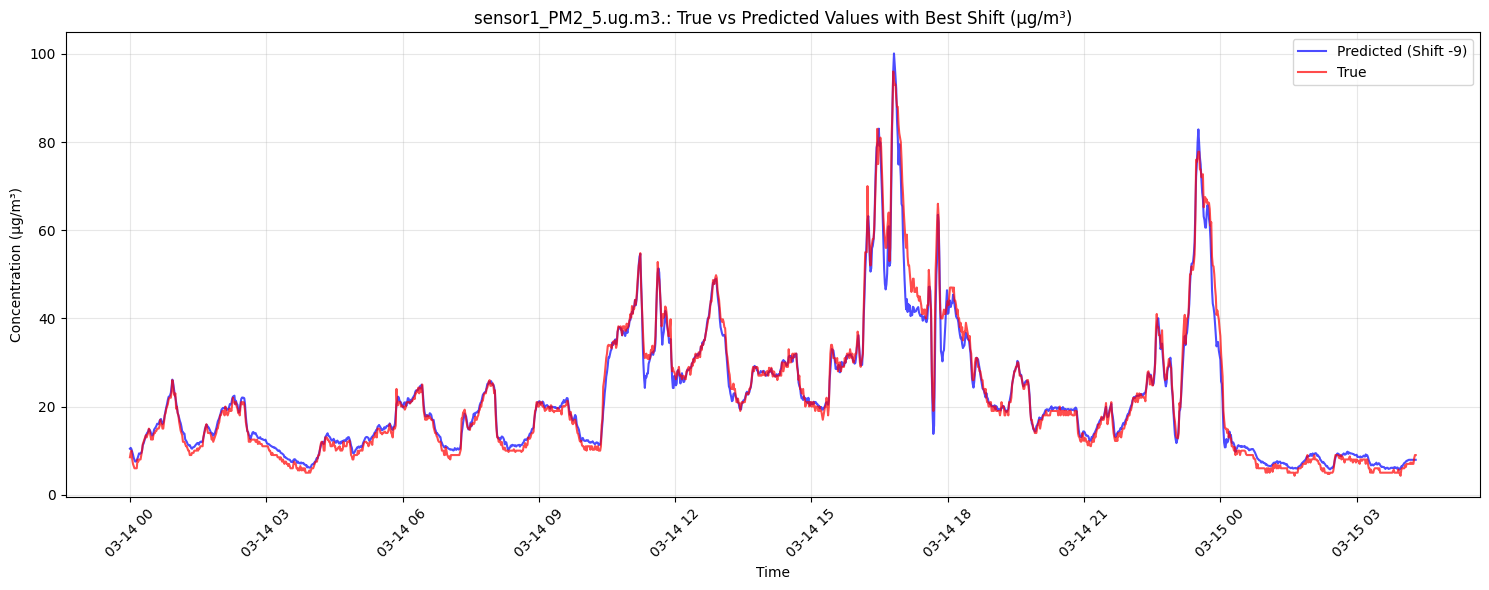


Best metrics for sensor1_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.3983
RMSE: 2.1370
R²: 0.9814
MAPE: 8.3887%

Processing sensor2
Loaded 1 variables from sensor: sensor2
Variables: ['sensor2_PM2_5.ug.m3.']
Training Data Length:  1 X 103680
Test Data Length:  1 X 25920
Testing percentage:  20.0 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1744 - val_loss: 0.0751
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1147 - val_loss: 0.0561
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0940 - val_loss: 0.0464
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0811 - val_loss: 0.0392
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0706 - val_loss: 0.0349
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0624 - val_loss: 0.0328
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0589 - val_loss: 0.0315
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0551 - val_loss: 0.0308
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0535 - val_loss: 0.0303
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0518 - val_loss: 0.0306
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0504 - val_loss: 0.0299
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


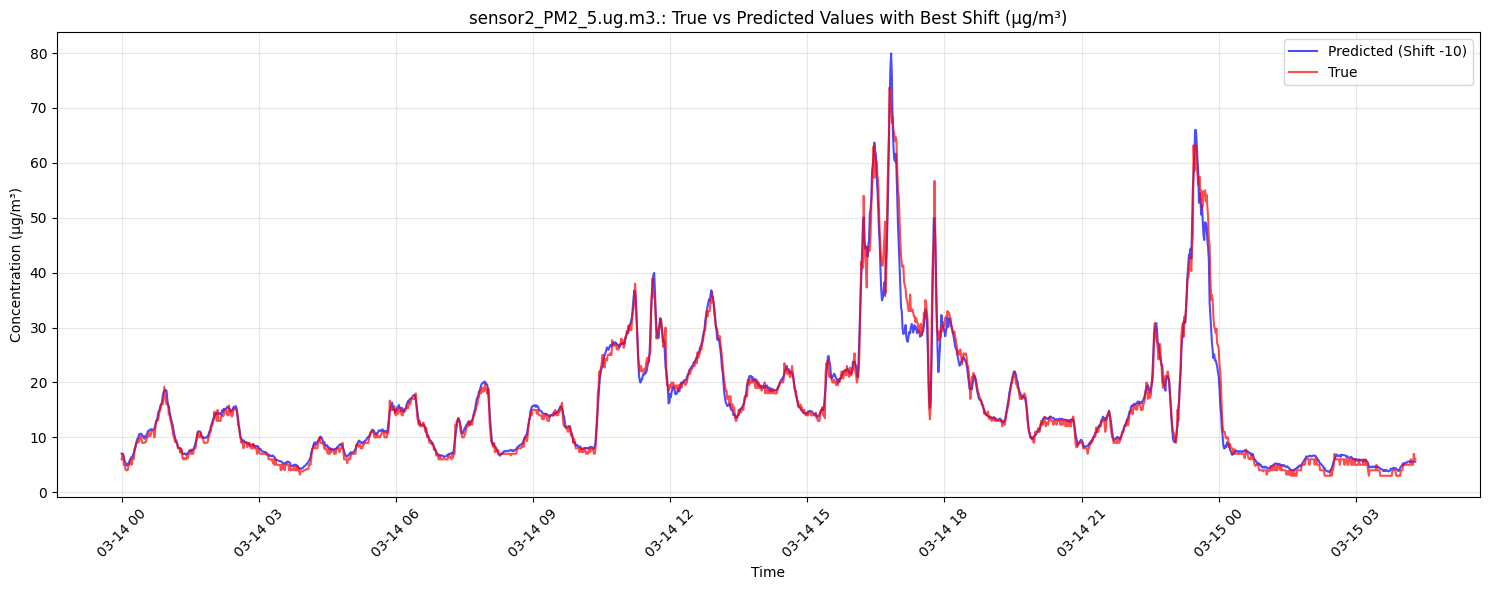


Best metrics for sensor2_PM2_5.ug.m3.:
Best Shift: -10 steps
MAE: 1.0502
RMSE: 1.7643
R²: 0.9777
MAPE: 8.0205%

Processing sensor3
Loaded 1 variables from sensor: sensor3
Variables: ['sensor3_PM2_5.ug.m3.']
Training Data Length:  1 X 103680
Test Data Length:  1 X 25920
Testing percentage:  20.0 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1854 - val_loss: 0.0706
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1126 - val_loss: 0.0484
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0838 - val_loss: 0.0389
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0708 - val_loss: 0.0337
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0625 - val_loss: 0.0315
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0564 - val_loss: 0.0308
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0559 - val_loss: 0.0302
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0527 - val_loss: 0.0296
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0521 - val_loss: 0.0298
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0505 - val_loss: 0.0297
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0498 - val_loss: 0.0290
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


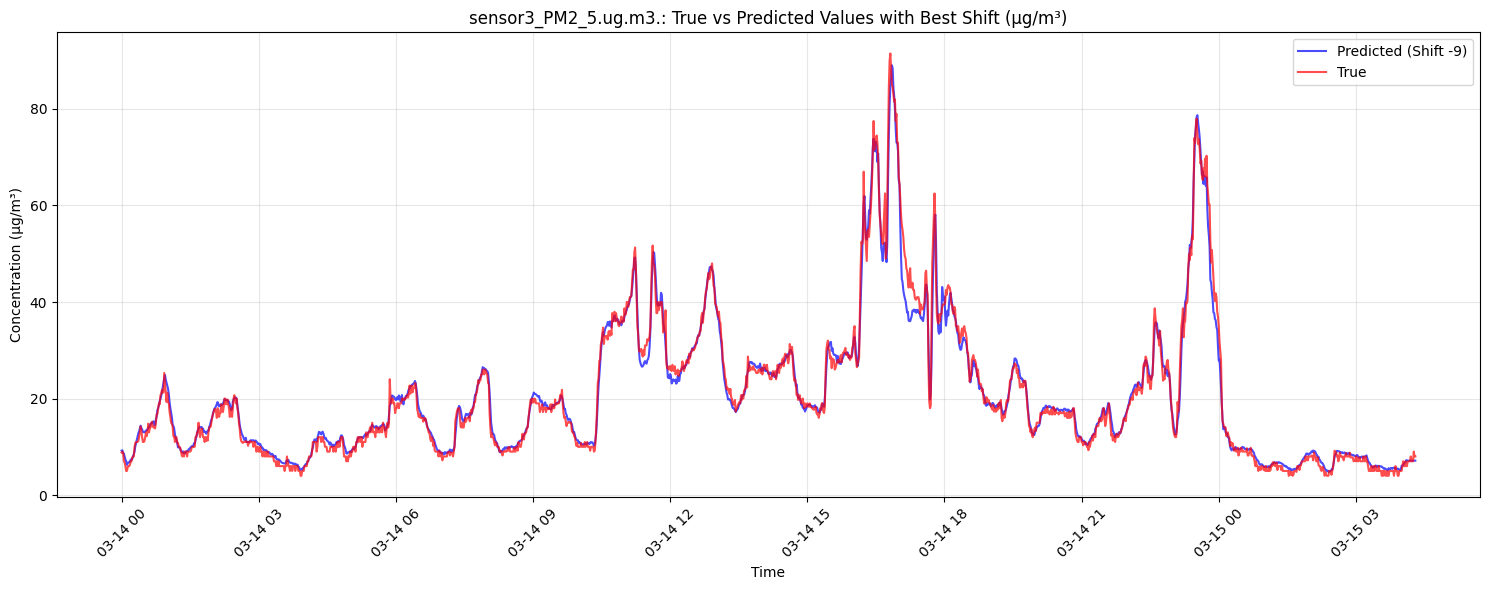


Best metrics for sensor3_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.2391
RMSE: 1.9317
R²: 0.9833
MAPE: 7.1696%

Processing sensor4
Loaded 1 variables from sensor: sensor4
Variables: ['sensor4_PM2_5.ug.m3.']
Training Data Length:  1 X 93891
Test Data Length:  1 X 23473
Testing percentage:  20.000170410006476 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1568 - val_loss: 0.0670
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0948 - val_loss: 0.0452
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0729 - val_loss: 0.0383
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0640 - val_loss: 0.0349
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0593 - val_loss: 0.0327
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0539 - val_loss: 0.0313
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0510 - val_loss: 0.0305
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0493 - val_loss: 0.0298
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0466 - val_loss: 0.0295
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0475 - val_loss: 0.0292
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0436 - val_loss: 0.0291
Epoch 12/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 1, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


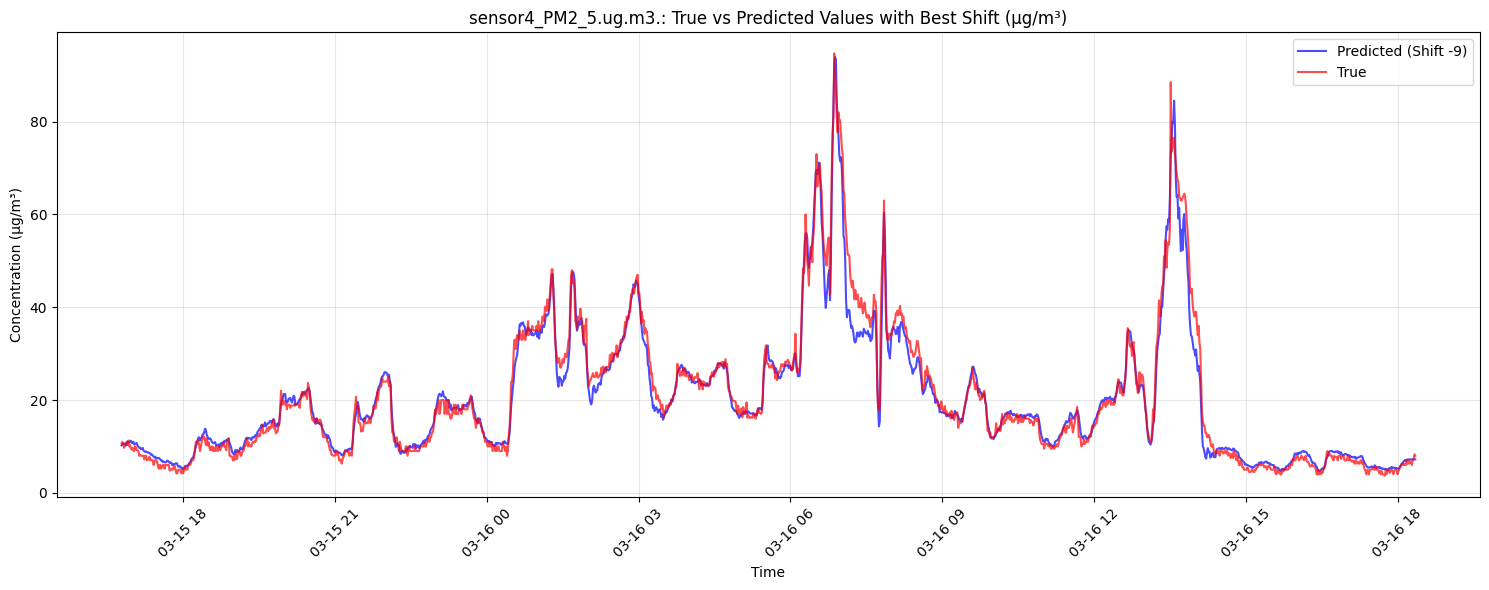


Best metrics for sensor4_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.6731
RMSE: 2.5836
R²: 0.9702
MAPE: 9.3506%


In [11]:
# Store results for all models
single_sensor_results = {}

# Loop through each sensor
for sensor_name, file_path in all_sensors.items():
    print(f"\n{'='*50}")
    print(f"Processing {sensor_name}")
    print(f"{'='*50}")

    # Dictionary to store data for this sensor
    sensor_data = {}
    time_index = None

        # Create a dictionary with just this sensor
    sensor_files = {sensor_name: file_path}

    # Load aligned data
    data, variable_names, time_index = load_and_align_data(sensor_files, variables)

    if not data:
        print(f"No valid data found for {sensor_name}. Skipping.")
        continue

    print(f"Loaded {len(data)} variables from sensor: {sensor_name}")
    print("Variables:", variable_names)

    # Train model and get predictions
    pred_y, test_y, model, scaling_params = SP_Learner(
        data,
        train_time,
        predict_time,
        predict_position,
        stride,
        start,
        end,
        f'AirQuality_{sensor_name}'
    )

    # Evaluate model
    results = evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start)

    # Store results
    single_sensor_results[sensor_name] = results

In [12]:
# ## Results Summary
#
# Compile all results into comprehensive tables for comparison.

# %%
# Create a consolidated results table for single sensor models
single_results_table = []
for sensor_name, results in single_sensor_results.items():
    for var_name, metrics in results.items():
        single_results_table.append({
            'Sensor': sensor_name,
            'Variable': var_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R²': metrics['R²'],
            'MAPE (%)': metrics['MAPE'],
            'Best Shift': metrics['Best Shift']
        })

single_df = pd.DataFrame(single_results_table)
print("Single Sensor Model Results:")
display(single_df)


Single Sensor Model Results:


,Sensor,Variable,MAE,RMSE,R²,MAPE (%),Best Shift
0,sensor1,sensor1_PM2_5.ug.m3.,1.398325,2.136962,0.981387,8.388701,-9
1,sensor2,sensor2_PM2_5.ug.m3.,1.050192,1.764336,0.977696,8.020501,-10
2,sensor3,sensor3_PM2_5.ug.m3.,1.239143,1.931745,0.983306,7.169573,-9
3,sensor4,sensor4_PM2_5.ug.m3.,1.673076,2.583580,0.970186,9.350616,-9


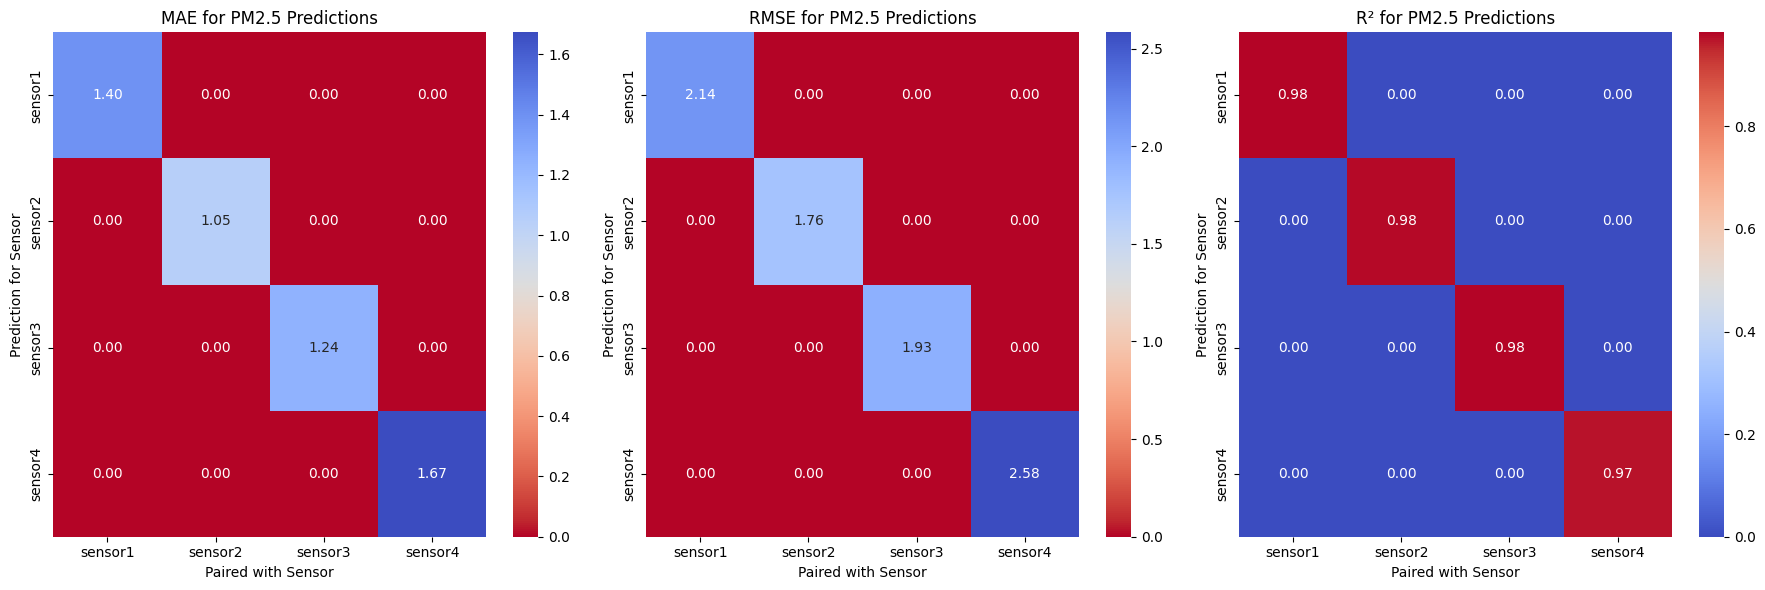

In [13]:
# Create a heatmap visualization for dual-sensor performance comparison
# Extract just the PM2.5 results
pm25_results = {}

# All sensor names
sensor_names = list(all_sensors.keys())

# Initialize metric matrices
mae_matrix = np.zeros((len(sensor_names), len(sensor_names)))
rmse_matrix = np.zeros((len(sensor_names), len(sensor_names)))
r2_matrix = np.zeros((len(sensor_names), len(sensor_names)))

# Fill in single sensor results on the diagonal
for i, sensor in enumerate(sensor_names):
    if sensor in single_sensor_results:
        for var_name, metrics in single_sensor_results[sensor].items():
            if 'PM2_5.ug.m3.' in var_name and sensor in var_name:
                mae_matrix[i, i] = metrics['MAE']
                rmse_matrix[i, i] = metrics['RMSE']
                r2_matrix[i, i] = metrics['R²']

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE Heatmap
sns.heatmap(mae_matrix, annot=True, fmt='.2f', cmap='coolwarm_r',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[0])
axes[0].set_title('MAE for PM2.5 Predictions')
axes[0].set_xlabel('Paired with Sensor')
axes[0].set_ylabel('Prediction for Sensor')

# RMSE Heatmap
sns.heatmap(rmse_matrix, annot=True, fmt='.2f', cmap='coolwarm_r',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[1])
axes[1].set_title('RMSE for PM2.5 Predictions')
axes[1].set_xlabel('Paired with Sensor')
axes[1].set_ylabel('Prediction for Sensor')

# R² Heatmap
sns.heatmap(r2_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[2])
axes[2].set_title('R² for PM2.5 Predictions')
axes[2].set_xlabel('Paired with Sensor')
axes[2].set_ylabel('Prediction for Sensor')

plt.tight_layout()
plt.show()